In [2]:
import os.path
from constant import *
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp
from data import loader, exporter
import matplotlib.pyplot as plt

In [3]:
def adversarial_validation_with_lightgbm(df, delete_ks_threshold=0.1):

   # Step 1: 分割训练集和测试集数据
    train_data = df[df['SRC'] == 'train']
    test_data = df[df['SRC'] == 'test']

    # 检查哪些特征仅在训练集或测试集中存在
    train_columns = set(train_data.columns)
    test_columns = set(test_data.columns)
    
    # 计算需要删除的特征（仅存在于训练集或测试集中的特征）
    exclusive_train_columns = train_columns - test_columns
    exclusive_test_columns = test_columns - train_columns
    columns_to_drop = list(exclusive_train_columns | exclusive_test_columns)

    # 检查是否存在列在测试集中全部为NaN或0的情况，或方差为0
    for feature in train_columns & test_columns:
        if test_data[feature].isna().all() or (test_data[feature] == 0).all() :
            columns_to_drop.append(feature)

    if columns_to_drop:
        print(f"Columns only in train or test, or have all NaN/0 in test, and will be dropped: {columns_to_drop}")

    # 剔除这些列
    df = df.drop(columns=columns_to_drop)

    # 分割成训练集和验证集
    y = df["SRC"].apply(lambda x: 1 if x == 'train' else 0)
    X = df.drop(columns=['SRC', 'CUST_NO'])

    feature_columns = X.columns.tolist()

    # 使用lightgbm进行分类
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
    train_data_lgb = lgb.Dataset(X_train, label=y_train)
    valid_data_lgb = lgb.Dataset(X_valid, label=y_valid, reference=train_data_lgb)

    # 使用LightGBM训练
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'early_stopping_round': 50
    }

    lgb_model = lgb.train(params, train_data_lgb, valid_sets=[valid_data_lgb])

    # 计算ROC AUC分数
    y_pred = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
    auc_score = roc_auc_score(y_valid, y_pred)

    print(f"Adversarial Validation AUC: {auc_score:.4f}")

    # 绘制多个特征的分布图在一个图表中
    num_features = len(feature_columns)

    # 创建子图时，根据特征数量确定布局
    if num_features == 1:
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.kdeplot(train_data[feature_columns[0]], label='Train', fill=True, ax=ax)
        sns.kdeplot(test_data[feature_columns[0]], label='Test', fill=True, ax=ax)
        ax.set_title(f"Distribution of {feature_columns[0]} in Train vs Test")
        ax.legend()
    else:
        fig, axes = plt.subplots(nrows=num_features // 2 + num_features % 2, ncols=2,
                                 figsize=(12, 6 * (num_features // 2)))
        axes = axes.flatten()

        for i, feature in enumerate(feature_columns):
            sns.kdeplot(train_data[feature], label='Train', fill=True, ax=axes[i])
            sns.kdeplot(test_data[feature], label='Test', fill=True, ax=axes[i])
            axes[i].set_title(f"Distribution of {feature} in Train vs Test")
            axes[i].legend()

    plt.tight_layout()
    plt.show()
    

    # Step 4: 计算特征在训练集和测试集中的 KS 检验差异
    columns_to_drop = []
    ks_results = []
    for feature in feature_columns:
        train_values = train_data[feature].dropna()
        test_values = test_data[feature].dropna()
        
        # var = 0 
        if test_values.var() == 0 or train_values.var() == 0:
            columns_to_drop.append(feature)
        
        # ks 大于阈值的
        statistic, p_value = ks_2samp(train_values, test_values)
        
        if statistic > delete_ks_threshold:
            columns_to_drop.append(feature)
        
        ks_results.append({'feature': feature, 'ks_statistic': statistic, 'p_value': p_value})
    
    # 显示 KS 检验结果
    ks_df = pd.DataFrame(ks_results).sort_values(by='ks_statistic', ascending=False)
    print("KS test results:")
    print(ks_df)

    # Step 5: 剔除 KS 差异过大的列
    if columns_to_drop:
        print(f"Columns with large KS difference and will be dropped: {columns_to_drop}")
        X = X.drop(columns=columns_to_drop)

    # 返回最终保留的特征列
    retained_features = X.columns.tolist()
    return retained_features




Columns only in train or test, or have all NaN/0 in test, and will be dropped: ['mean_RMB_TR_AMT_0.0_1.0_TRS_CSH_IND_CSH_EX_IND', 'mean_ARG_ACCT_BAL_0.0_1.0_TRS_CSH_IND_CSH_EX_IND', 'mean_ARG_ACCT_BAL_16459755d990723240edb88e34a13fab_0.0_1.0_ACTG_DIRET_CD_TRS_CSH_IND_CSH_EX_IND', 'sum_RMB_TR_AMT_16459755d990723240edb88e34a13fab_0.0_1.0_ACTG_DIRET_CD_TRS_CSH_IND_CSH_EX_IND', 'mean_RMB_TR_AMT_16459755d990723240edb88e34a13fab_0.0_1.0_ACTG_DIRET_CD_TRS_CSH_IND_CSH_EX_IND', 'sum_ARG_ACCT_BAL_16459755d990723240edb88e34a13fab_0.0_1.0_ACTG_DIRET_CD_TRS_CSH_IND_CSH_EX_IND', 'sum_RMB_TR_AMT_0.0_1.0_TRS_CSH_IND_CSH_EX_IND', 'FLAG', 'sum_ARG_ACCT_BAL_0.0_1.0_TRS_CSH_IND_CSH_EX_IND']
[1]	valid_0's auc: 0.500392
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.499149
[3]	valid_0's auc: 0.496852
[4]	valid_0's auc: 0.496966
[5]	valid_0's auc: 0.498332
[6]	valid_0's auc: 0.498867
[7]	valid_0's auc: 0.499419
[8]	valid_0's auc: 0.497165
[9]	valid_0's auc: 0.499899
[10]	va

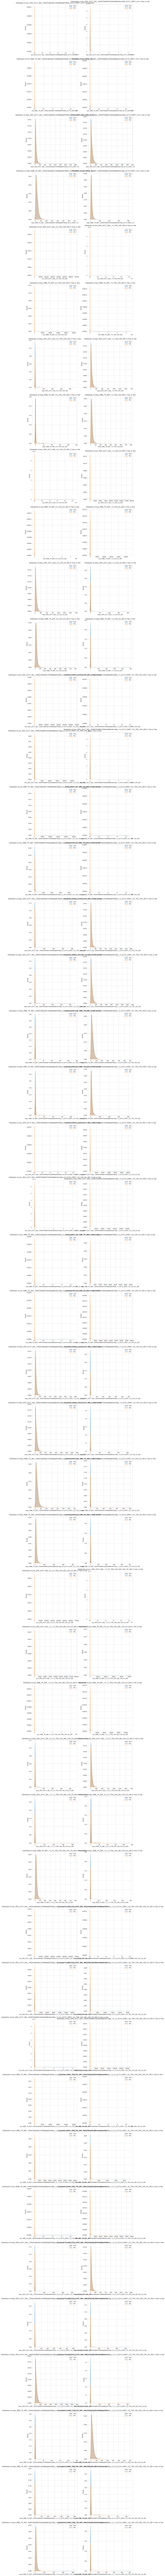

KS test results:
                                              feature  ks_statistic   p_value
15                    mean_RMB_TR_AMT_1.0_TRS_CSH_IND      0.014535  0.203988
37  mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe6...      0.014399  0.212819
6   mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe6...      0.014345  0.216403
87  mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe6...      0.014276  0.221009
52  mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe6...      0.014222  0.224698
..                                                ...           ...       ...
61      sum_RMB_TR_AMT_1.0_1.0_TRS_CSH_IND_CSH_EX_IND      0.001189  1.000000
73  sum_ARG_ACCT_BAL_16459755d990723240edb88e34a13...      0.001091  1.000000
43  sum_ARG_ACCT_BAL_16459755d990723240edb88e34a13...      0.001091  1.000000
85  mean_ARG_ACCT_BAL_16459755d990723240edb88e34a1...      0.000847  1.000000
51  mean_ARG_ACCT_BAL_16459755d990723240edb88e34a1...      0.000847  1.000000

[92 rows x 3 columns]


In [7]:

df_target = pd.read_csv(f'{dir_preprocess}/target.csv')
df_flat = pd.read_csv(f'{dir_preprocess}/expend_1.csv')
df_flat = df_flat.merge(df_target, left_on=['CUST_NO'], right_on=['CUST_NO'], how='inner')

retained_features = adversarial_validation_with_lightgbm(df_flat)


Columns only in train or test, or have all NaN/0 in test, and will be dropped: ['FLAG']
[1]	valid_0's auc: 0.500392
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.499149
[3]	valid_0's auc: 0.496852
[4]	valid_0's auc: 0.496966
[5]	valid_0's auc: 0.498332
[6]	valid_0's auc: 0.498867
[7]	valid_0's auc: 0.499419
[8]	valid_0's auc: 0.497165
[9]	valid_0's auc: 0.499899
[10]	valid_0's auc: 0.501155
[11]	valid_0's auc: 0.497837
[12]	valid_0's auc: 0.499085
[13]	valid_0's auc: 0.498396
[14]	valid_0's auc: 0.497889
[15]	valid_0's auc: 0.496338
[16]	valid_0's auc: 0.495397
[17]	valid_0's auc: 0.496784
[18]	valid_0's auc: 0.496359
[19]	valid_0's auc: 0.496637
[20]	valid_0's auc: 0.497501
[21]	valid_0's auc: 0.495798
[22]	valid_0's auc: 0.496942
[23]	valid_0's auc: 0.497855
[24]	valid_0's auc: 0.497864
[25]	valid_0's auc: 0.498562
[26]	valid_0's auc: 0.497838
[27]	valid_0's auc: 0.497035
[28]	valid_0's auc: 0.496532
[29]	valid_0's auc: 0.499504
[30]	valid_0's auc:

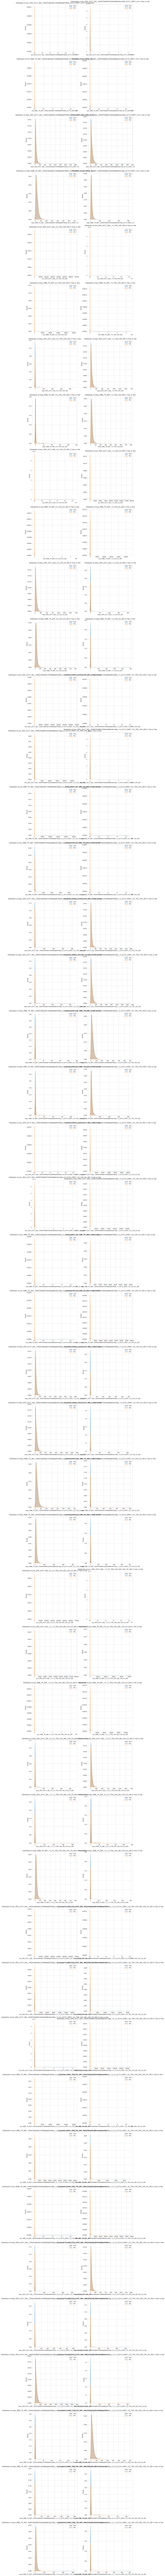

KS test results:
                                              feature  ks_statistic   p_value
15                    mean_RMB_TR_AMT_1.0_TRS_CSH_IND      0.014535  0.203988
37  mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe6...      0.014399  0.212819
6   mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe6...      0.014345  0.216403
87  mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe6...      0.014276  0.221009
52  mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe6...      0.014222  0.224698
..                                                ...           ...       ...
61      sum_RMB_TR_AMT_1.0_1.0_TRS_CSH_IND_CSH_EX_IND      0.001189  1.000000
73  sum_ARG_ACCT_BAL_16459755d990723240edb88e34a13...      0.001091  1.000000
43  sum_ARG_ACCT_BAL_16459755d990723240edb88e34a13...      0.001091  1.000000
85  mean_ARG_ACCT_BAL_16459755d990723240edb88e34a1...      0.000847  1.000000
51  mean_ARG_ACCT_BAL_16459755d990723240edb88e34a1...      0.000847  1.000000

[92 rows x 3 columns]


['sum_ARG_ACCT_BAL_1250d7cb654a81c7b9366dabf57fe62b_ACTG_DIRET_CD',
 'sum_ARG_ACCT_BAL_16459755d990723240edb88e34a13fab_ACTG_DIRET_CD',
 'sum_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe62b_ACTG_DIRET_CD',
 'sum_RMB_TR_AMT_16459755d990723240edb88e34a13fab_ACTG_DIRET_CD',
 'mean_ARG_ACCT_BAL_1250d7cb654a81c7b9366dabf57fe62b_ACTG_DIRET_CD',
 'mean_ARG_ACCT_BAL_16459755d990723240edb88e34a13fab_ACTG_DIRET_CD',
 'mean_RMB_TR_AMT_1250d7cb654a81c7b9366dabf57fe62b_ACTG_DIRET_CD',
 'mean_RMB_TR_AMT_16459755d990723240edb88e34a13fab_ACTG_DIRET_CD',
 'sum_ARG_ACCT_BAL_0.0_TRS_CSH_IND',
 'sum_ARG_ACCT_BAL_1.0_TRS_CSH_IND',
 'sum_RMB_TR_AMT_0.0_TRS_CSH_IND',
 'sum_RMB_TR_AMT_1.0_TRS_CSH_IND',
 'mean_ARG_ACCT_BAL_0.0_TRS_CSH_IND',
 'mean_ARG_ACCT_BAL_1.0_TRS_CSH_IND',
 'mean_RMB_TR_AMT_0.0_TRS_CSH_IND',
 'mean_RMB_TR_AMT_1.0_TRS_CSH_IND',
 'sum_ARG_ACCT_BAL_0.0_CSH_EX_IND',
 'sum_ARG_ACCT_BAL_1.0_CSH_EX_IND',
 'sum_RMB_TR_AMT_0.0_CSH_EX_IND',
 'sum_RMB_TR_AMT_1.0_CSH_EX_IND',
 'mean_ARG_ACCT_BAL_0.0_CSH_

In [8]:
df_after_adv = df_flat[retained_features + ['CUST_NO','SRC','FLAG']]
adversarial_validation_with_lightgbm(df_after_adv)